#Image Classification on CIFAR-10
In this problem we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. Make sure that you are familiar with tensors, two-dimensional convolutions (`nn.Conv2d`) and fully-connected layers (`nn.Linear`), ReLU non-linearities (`F.relu`), pooling (`nn.MaxPool2d`), and tensor reshaping (`view`).

We will use Colab because it has GPUs available. **You will need to enable them**. To do so, click "Runtime" above and then "Change runtime type". There under hardware accelerator choose "GPU".

Now are ready imports necessary for the problem:

In [1]:
import torch
from torch import nn
import torchvision

# Plotting
import matplotlib.pyplot as plt

# Nice progress bars. Might be useful for this problem
from tqdm import tqdm, trange
from  torch.utils.data import random_split, DataLoader


from torch.nn import Module
from torch.nn.functional import cross_entropy, relu
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets


Let's verify that we are using a gpu:

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


To use the GPU you will need to cast both the model and data to a device.
```python
model = model.to(DEVICE)  # Casting a model

for x, y in tqdm(data_loader):
  x, y = x.to(DEVICE), y.to(DEVICE)
```
When reading tensors you will need to send them back to cpu, you can do so with `x = x.cpu()`.

Lastly, let's load CIFAR-10 data. This is how we load datasets using PyTorch in the real world!

In [3]:
transform_train = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True,  transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True,  transform=transform_train)

Files already downloaded and verified
Files already downloaded and verified


The rest is yours to code! You can structure the code any way you would like!

We do advise making use many code cells and functions (train, search, predict etc.), since they will make your code run faster and easier to debug! 

In [4]:
class F1(Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(32*32*3,10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
       
        x = x.view(-1,32*32*3)
        x = self.layer(x)
        return x
class F2(Module):
    def __init__(self, M):
        super().__init__()
        self.layer1 = nn.Linear(32*32*3,M)
        self.layer2 = nn.Linear(M,10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
       
        x = x.view(-1,32*32*3)
        x = relu(self.layer1(x))
        x = self.layer2(x) 
        return x


In [5]:
batch_size = 128
train_size, val_size = int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)

tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [18]:
def train(mdoel, optimizier, train_loader, loss_fun):
  loss_ls_epoch = 0
  total_train = 0
  error_epoch = 0

  for batch in train_loader:
      x, y = batch[0].cuda(), batch[1].cuda()
      y_pred = model(x)
      loss = loss_fun(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_ls_epoch += loss.data.cpu()
      y_hat_test = y_pred.max(dim=1)[1]
      error_epoch += torch.count_nonzero(y_hat_test - y)
      total_train += len(x)
      train_loss = (loss_ls_epoch / total_train)
      error = 1 - (error_epoch.cpu() / total_train)

      loss_ls_epoch += loss.data.cpu()
      total_train += len(x)
  train_loss = (loss_ls_epoch / total_train)
  error = 1 - (error_epoch.cpu() / total_train)
  print('train loss is ', str(train_loss))
  return error

def val(mdoel, val_loader, loss_fun):
  loss_ls_epoch = 0
  total_train = 0
  error_epoch = 0

  for batch in val_loader:
      x, y = batch[0].cuda(), batch[1].cuda()
      y_pred = model(x)
      loss = loss_fun(y_pred, y)

      loss_ls_epoch += loss.data.cpu()
      y_hat_test = y_pred.max(dim=1)[1]
      error_epoch += torch.count_nonzero(y_hat_test - y)
      total_train += len(x)
  train_loss = (loss_ls_epoch / total_train)
  error = 1 - (error_epoch.cpu() / total_train)

  print('val loss is ', str(train_loss))
  print('val acc is ', str(error))
  return error


# 1. F1

In [ ]:
M=100
k=5
N=14
lr = 0.0001
loss = cross_entropy
epochs = 10


M = [1024, 512, 256, 128]
k = [5, 3]
N = [14, 10]
# model_list = [F1(), F2(M), F3(M, k, N)]
lr_ls = [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01]



final_dic = dict()
count = 1
for i, lr in enumerate(lr_ls):
  model = F1().cuda()
  train_loss_ls = []
  val_loss_ls = []
  error_ls = []
  optimizer = Adam(model.parameters(), lr=lr)
  dic = dict()
  for epoch in range(epochs):
    print('epoch',epoch)
    train_error = train(model,optimizer,train_loader, loss)
    val_error = val(model,val_loader, loss)
    train_loss_ls.append(train_error.cpu())
    val_loss_ls.append(val_error.cpu())
  dic['train_error'] = train_loss_ls
  dic['val_error'] = val_loss_ls
  dic['model'] = model
  final_dic[count] = dic
  count += 1

In [ ]:
## plot
for dic in final_dic.keys():
    if dic < 6:
        plt.plot(final_dic[dic]['train_error'])
        plt.plot(final_dic[dic]['val_error'])
label = []
for lr in lr_ls[:5]:
    train = ['train error, lr= ', str(lr)]
    train = ''.join(train)
    label.append(train)
    val = ['val error, lr= ', str(lr)]
    val = ''.join(val)
    label.append(val)
plt.legend(label)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('F1 train error, val error v.s. epoch')
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.savefig('hw4b2.png', dpi=100)


# 2.F2

In [ ]:
M=100
k=5
N=14
lr = 0.0001
loss = cross_entropy
epochs = 10


M = [1024, 512, 256, 128]
k = [5, 3]
N = [14, 10]
# model_list = [F1(), F2(M), F3(M, k, N)]
lr_ls = [0.0001, 0.0005]



final_dic = dict()
COUNT = 1
for lr in lr_ls:
    for m in M:
        print('nuber of hyperparameter '+str(COUNT))
        dic = dict()
        model = F2(m).cuda()
        train_loss_ls = []
        val_loss_ls = []
        error_ls = []
        optimizer = Adam(model.parameters(), lr=lr)
        for epoch in range(epochs):
            print('epoch',epoch)
            train_error = train(model,optimizer,train_loader, loss)
            val_error = val(model,val_loader, loss)
            train_loss_ls.append(train_error.cpu())
            val_loss_ls.append(val_error.cpu())
        dic['train_error'] = train_loss_ls
        dic['val_error'] = val_loss_ls
        dic['model'] = model
        final_dic[COUNT] = dic
        COUNT += 1

In [ ]:
# plot
for dic in final_dic.keys():
    if dic < 6:
        plt.plot(final_dic[dic]['train_error'])
        plt.plot(final_dic[dic]['val_error'])
label = []
M = [1024, 512]
for lr in lr_ls:
    for m in M:
        train = ['train error, M= ',str(m),' lr= ', str(lr)]
        train = ''.join(train)
        label.append(train)
        val = ['val error, M= ',str(m),' lr= ', str(lr)]
        val = ''.join(val)
        label.append(val)
train = ['train error, M= 256 lr= 0.0001']
train = ''.join(train)
label.append(train)
val = ['val error, M= M= 256 lr= 0.000']
val = ''.join(val)
label.append(val)
plt.legend(label)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('F2 train error, val error v.s. epoch')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('hw4b1.png', dpi=100)



In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
model = final_dic[1]['model']
val_error = val(model,test_loader, cross_entropy)

# F3

In [7]:
loss = cross_entropy
epochs = 35

class F3(Module):
    def __init__(self, M, k, N):
        super().__init__()
        self.conv = nn.Conv2d(3,M,(k,k))
        self.layer = nn.Linear(M*(33-k)//N*(33-k)//N,10)
        self.pool = nn.MaxPool2d(kernel_size=(k,k), stride=N)
        self.M = M
        self.k = k
        self.N = N

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = relu(self.conv(x))
        x = self.pool(x).view(-1,self.M*(33-self.k)//self.N*(33-self.k)//self.N)
        x = self.layer(x) 
        return x

M = [512, 256, 100]
k = [5, 3]
N = [14, 6]
lr_ls = [0.0001, 0.0005]



final_dic = dict()
COUNT = 1
top_5 = [8,10,12,2,4]
for lr in lr_ls:
    for m in M:
        for i in range(len(k)):
            print('nuber of hyperparameter '+str(COUNT))
            print('k = '+str(5)+', m = '+str(m)+', lr = ' +str(lr))
            if COUNT in top_5:
                dic = dict()
                model = F3(m,k[i], N[i]).cuda()
                train_loss_ls = []
                val_loss_ls = []
                error_ls = []
                optimizer = Adam(model.parameters(), lr=lr)
                for epoch in range(epochs):
                    print('epoch',epoch)
                    train_error = train(model,optimizer,train_loader, loss)
                    val_error = val(model,val_loader, loss)
                    train_loss_ls.append(train_error.cpu())
                    val_loss_ls.append(val_error.cpu())
                dic['train_error'] = train_loss_ls
                dic['val_error'] = val_loss_ls
                dic['model'] = model
                final_dic[COUNT] = dic
            COUNT += 1

nuber of hyperparameter 1
k = 5, m = 512, lr = 0.0001
nuber of hyperparameter 2
k = 5, m = 512, lr = 0.0001
epoch 0


/home/neuroai/anaconda3/envs/cse446/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss is  tensor(0.0130)
val loss is  tensor(0.0117)
val acc is  tensor(0.4924)
epoch 1
train loss is  tensor(0.0111)
val loss is  tensor(0.0108)
val acc is  tensor(0.5291)
epoch 2
train loss is  tensor(0.0103)
val loss is  tensor(0.0103)
val acc is  tensor(0.5601)
epoch 3
train loss is  tensor(0.0099)
val loss is  tensor(0.0099)
val acc is  tensor(0.5727)
epoch 4
train loss is  tensor(0.0095)
val loss is  tensor(0.0096)
val acc is  tensor(0.5888)
epoch 5
train loss is  tensor(0.0093)
val loss is  tensor(0.0094)
val acc is  tensor(0.5981)
epoch 6
train loss is  tensor(0.0090)
val loss is  tensor(0.0092)
val acc is  tensor(0.6040)
epoch 7
train loss is  tensor(0.0088)
val loss is  tensor(0.0094)
val acc is  tensor(0.5948)
epoch 8
train loss is  tensor(0.0087)
val loss is  tensor(0.0091)
val acc is  tensor(0.6106)
epoch 9
train loss is  tensor(0.0085)
val loss is  tensor(0.0090)
val acc is  tensor(0.6127)
epoch 10
train loss is  tensor(0.0084)
val loss is  tensor(0.0089)
val acc is 

val loss is  tensor(0.0081)
val acc is  tensor(0.6539)
epoch 15
train loss is  tensor(0.0061)
val loss is  tensor(0.0083)
val acc is  tensor(0.6521)
epoch 16
train loss is  tensor(0.0060)
val loss is  tensor(0.0082)
val acc is  tensor(0.6434)
epoch 17
train loss is  tensor(0.0058)
val loss is  tensor(0.0081)
val acc is  tensor(0.6548)
epoch 18
train loss is  tensor(0.0057)
val loss is  tensor(0.0083)
val acc is  tensor(0.6522)
epoch 19
train loss is  tensor(0.0056)
val loss is  tensor(0.0079)
val acc is  tensor(0.6583)
epoch 20
train loss is  tensor(0.0055)
val loss is  tensor(0.0082)
val acc is  tensor(0.6539)
epoch 21
train loss is  tensor(0.0054)
val loss is  tensor(0.0080)
val acc is  tensor(0.6636)
epoch 22
train loss is  tensor(0.0053)
val loss is  tensor(0.0079)
val acc is  tensor(0.6647)
epoch 23
train loss is  tensor(0.0052)
val loss is  tensor(0.0079)
val acc is  tensor(0.6584)
epoch 24
train loss is  tensor(0.0051)
val loss is  tensor(0.0081)
val acc is  tensor(0.6619)
epoch

train loss is  tensor(0.0067)
val loss is  tensor(0.0083)
val acc is  tensor(0.6451)
epoch 31
train loss is  tensor(0.0066)
val loss is  tensor(0.0082)
val acc is  tensor(0.6364)
epoch 32
train loss is  tensor(0.0066)
val loss is  tensor(0.0082)
val acc is  tensor(0.6415)
epoch 33
train loss is  tensor(0.0066)
val loss is  tensor(0.0081)
val acc is  tensor(0.6489)
epoch 34
train loss is  tensor(0.0066)
val loss is  tensor(0.0082)
val acc is  tensor(0.6483)


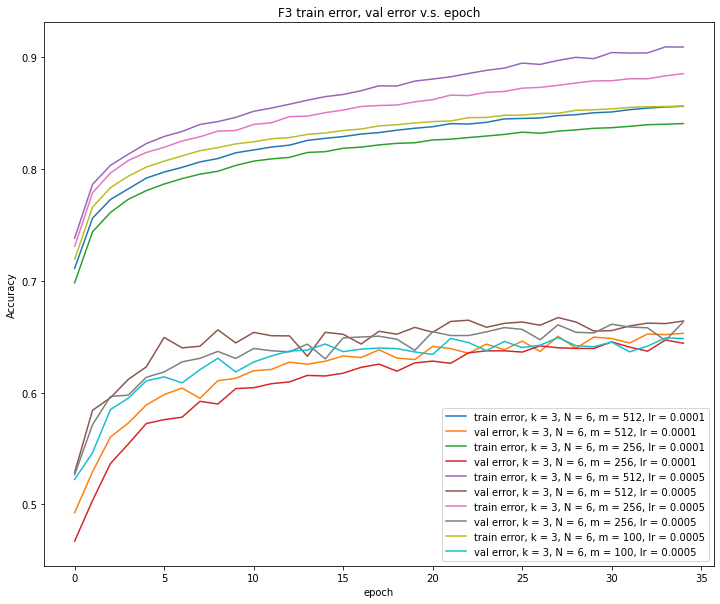

In [32]:
top_5 = {'1':8,'2':10,'3':12,'4':2,'5':4}
top_5 = [2,3,6,7,14,15,18,19,22,23]
M = [512, 256, 100]
k = [5, 3]
N = [14, 6]
lr_ls = [0.0001, 0.0005]
label = []
for lr in lr_ls:
    for m in M:
        for i in range(len(k)):
            train = 'train error, k = '+str(k[i]), ', N = '+str(N[i]), ', m = '+str(m)+', lr = ' +str(lr)
            train = ''.join(train)
            label.append(train)
            val = 'val error, k = '+str(k[i]), ', N = '+str(N[i]), ', m = '+str(m)+', lr = ' +str(lr)
            val = ''.join(val)
            label.append(val)

labels=[]
for i in top_5:
    labels.append(label[i])
for dic in final_dic.keys():
    plt.plot(final_dic[dic]['train_error'])
    plt.plot(final_dic[dic]['val_error'])

plt.legend(labels)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('F3 train error, val error v.s. epoch')
fig = plt.gcf()
fig.set_size_inches(12, 10)
plt.savefig('hw4b3.png', dpi=100)

In [24]:
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
model = final_dic[8]['model']
val_error = val(model,test_loader, cross_entropy)

val loss is  tensor(0.0043)
val acc is  tensor(0.6583)


In [25]:
for dic in final_dic.keys():
    print(final_dic[dic]['val_error'][-1])

tensor(0.6530)
tensor(0.6441)
tensor(0.6640)
tensor(0.6633)
tensor(0.6483)
